Démonstration Français-Anglais

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist, cosine
import torch         

from scipy.linalg import svd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LeakyReLU, Input, BatchNormalization, GaussianNoise
from keras.optimizers import SGD, Adagrad
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model

from time import time
import pickle
import pandas as pd

#pour les embeddings BERT et camemBERT
!pip install transformers
from transformers import BertTokenizer, BertModel, BertConfig
from transformers.tokenization_camembert import CamembertTokenizer
from transformers import CamembertConfig
from transformers.modeling_camembert import CamembertModel

#Chargement Pour les embeddings FastText
! curl -Lo wiki.en.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
! curl -Lo wiki.fr.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec

#Pour les dictionaires
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries.tar.gz
!tar -xf dictionaries.tar.gz

Classe définissant une langue (commune à tous les usages ci-bas)

In [2]:
class Language:
    def __init__(self, name, file_path):
        self.name = name
        
        f = open(file_path, "r")
        lines = f.readlines(int(1e8))[1:]
        f.close()
 
        self.vec, self.voc = get_vectors(lines, 2)
        self.embd_size = self.vec.shape[1]
        self.voc_size = self.vec.shape[0]
        
 
    def most_similar(self, positive, negative, n=1):
        v = np.zeros((1,self.embd_size))
 
        for neg in negative:
            i = np.where(self.voc == neg)[0][0]
            v -= self.vec[i]
 
        for pos in positive:
            i = np.where(self.voc == pos)[0][0]
            v += self.vec[i]
 
        distances = cdist(v, self.vec, metric="cosine")[0]
        indices = np.argsort(distances)[:n]
        d = [(self.voc[i], distances[i]) for i in indices]
 
        return d, v
 
 
def get_vectors(lines, word_min_len):
    vectors = []
    words = []
    for line in lines:
        v = line.rstrip().split(' ')[1:]
        w = line.rstrip().split(' ')[0]
 
        if(len(w) >= word_min_len):
            vectors.append(v)
            words.append(w)
   
    vectors = np.array(vectors).astype("float32")
    words = np.array(words)
 
    return vectors, words

# I- Manipulation des Embeddings

In [3]:
en = Language("english", "wiki.en.vec")
fr = Language("french", "wiki.fr.vec")

## Additivité des embeddings

### Embeddings FastText

In [ ]:
print(fr.most_similar(positive=["reine", "fils"], negative=["roi"], n=3)[0])
print(en.most_similar(positive=["king", "daughter"], negative=["queen"], n=3)[0])
print(en.most_similar(["france", "london"], ["paris"], 3)[0])
print(en.most_similar(["his", "woman"], ["man"] , 3)[0])

[('fille', 0.3345863085156682), ('sœur', 0.34031535896605214), ('fils', 0.3440339465691806)]
[('son', 0.24541592450735095), ('daughter', 0.26853436514483564), ('grandson', 0.31381364708011383)]
[('britain', 0.32707504641660723), ('london', 0.3368515471249046), ('england', 0.3409831671550798)]
[('her', 0.26435637196236983), ('his', 0.33542223620652734), ('she', 0.40407276146948645)]


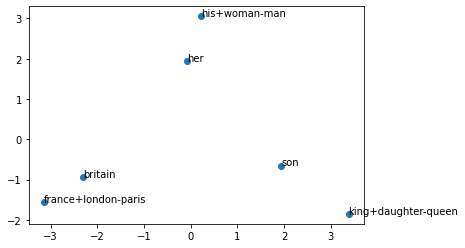

In [ ]:
def f(langue, l):
    vec = []
    label = []
    for i in l:
        m, v = langue.most_similar(i["positive"], i["negative"], 1)
        vec.append(v[0,:])
        label.append("-".join(["+".join(i["positive"])] + i["negative"]))
        vec.append(langue.vec[np.where(langue.voc == m[0][0])[0][0]])
        
        label.append(m[0][0])
    vec = np.array(vec)
    
    pca = PCA(2)
    pca.fit(vec)
    points = pca.transform(vec)
    plt.scatter(points[:,0], points[:,1])
    
    for i in range(points.shape[0]):
        plt.annotate(label[i], (points[i,0], points[i,1]))

f(en, [{"positive":["his", "woman"], "negative":["man"]}
       , {"positive":["king", "daughter"], "negative":["queen"]}
       , {"positive":["france", "london"], "negative":["paris"]}])

###Embeddings BERT et cameBERT

In [ ]:
#Chargement des modèles 

#pour le français:
# camembert_tokenizer = CamembertTokenizer.from_pretrained("camembert-base")    
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True)
# camembert_model = CamembertModel.from_pretrained("camembert-base", config=config)
# camembert_model.eval()

#pour l'anglais:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model.eval()

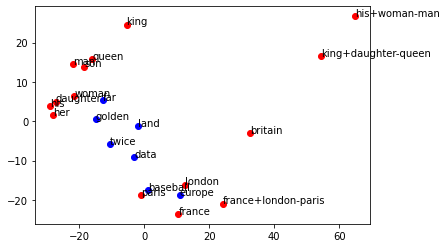

In [ ]:
 #https://huggingface.co/camembert-base
 #https://stackoverflow.com/questions/59030907/nlp-transformers-best-way-to-get-a-fixed-sentence-embedding-vector-shape

def get_embedding(word, model, tokenizer):
    
    token_ids = tokenizer.encode(word)
    if len(token_ids)==3:               # si le mot est dans le vocabulaire (sinon il aura été fragmenté et il y aurait eu plus de 3 tokens)
      
      tokens = [tokenizer._convert_id_to_token(idx) for idx in token_ids]
      token_ids = torch.tensor(token_ids).unsqueeze(0)     
      embd, _, all_layers_embeddings  = model(token_ids)
      unsq= lambda x: x.squeeze(0) 
      all_layers_embeddings = list(map(unsq, all_layers_embeddings))    
      embedding=np.sum(all_layers_embeddings[-4:])[1]
      embedding.detach().numpy() 

    else: 
      embedding =np.repeat(np.NaN, 768)  #la taille d'un vecteur camemBERT est de 768
    
    return  embedding

def plot_vecs(mots, vecs, len_first):
    
    vecs =(torch.stack(vecs)).detach().numpy()
    
    pca = PCA(2)
    pca.fit(vecs)
    points = pca.transform(vecs)
    plt.scatter(points[:len_first,0], points[:len_first,1], c='red')
    plt.scatter(points[len_first:,0], points[len_first:,1], c='blue')    
    
    for i in range(points.shape[0]):
        plt.annotate(mots[i], (points[i,0], points[i,1]))


mots_init=["france","london","paris","britain","king","daughter","queen","son","his","woman","man","her"]
vecs, mots1=[], []
do=0
for i,mot in enumerate(mots_init):
  vecs.append(get_embedding(mot, bert_model, bert_tokenizer))
  mots1.append(mot)
  
  if i%2==0 and i!=0:
    do=1-do
    if do:
      vecs.append(vecs[i-2]+vecs[i-1]-vecs[i])
      mots1.append(mots_init[i-2]+"+"+mots_init[i-1]+"-"+mots_init[i])

mots2=["twice","far", "land", "golden","baseball", "europe","data"]   
vecs2=[]
for mot in mots2:
  vecs2.append(get_embedding(mot, bert_model, bert_tokenizer))
mots=mots1+mots2
vecs=vecs+vecs2
plot_vecs(mots, vecs, len(mots1))
#le but du graphique en utilisant des embeddings BERT/camemBERT est de montrer que ces proriétés sur les espaces des embeddings sont vraies
#pour tous les embeddings (issus de Word2Vec ou autres modèles) mais le graphique tel qu'il est ci-bas ne le montre pas.
#Je pense qu'il est important (meme pour le graphe d'en haut) d'ajouter, en plus des mots d'illustration, d'autres mots; pour montrer la proximité qu'on veut
#montrer (pcq c'est relatif, il faut avoir plus de mots dans les alentours pour voir la proximité )

#II- Traduction 

##Définitions

In [4]:
 class Translator:
    def __init__(self, source_language, target_language):
        self.source = source_language
        self.target = target_language
        self.W = np.zeros((self.target.embd_size, self.source.embd_size))
 
 
    def translate(self, words, n=1):
        # words : liste de mots
        # n : nombre de traductions voulues
 
        vectors = np.zeros((len(words), self.source.embd_size))
 
        for i, w in enumerate(words):
            j = np.where(self.source.voc == w)[0]
            if len(j) > 0: 
                vectors[i] = self.source.vec[j]
            else: # w n'est pas dans le voc
                vectors[i] = np.repeat(np.NaN, self.source.embd_size)
 
        trslt_vec = np.dot(vectors, self.W)
 
        distances = cdist(trslt_vec, self.target.vec, metric="cosine") 
        indices = np.argsort(distances, axis=1)[:,:n]
        translations = self.target.voc[indices]
        
        return [(words[i], list(translations[i])) for i in range(len(words))]

    def process(self, dictionary):
    # dictionary : data frame avec une colonne par langue et une ligne par paire de mot

      X = []
      y = []
      dic = {}

      if dictionary is None: #construction d'un dicionaire avec les mots identiques seulement
          inverse_index = { element: index for index, element in enumerate(self.target.voc) }
          for index, element in enumerate(self.source.voc):
              if element in inverse_index:
                  X.append(self.source.vec[index])
                  y.append(self.target.vec[inverse_index[element]])
                  dic[element] = [self.target.voc[inverse_index[element]]]
      else:
          for i in range(dictionary.shape[0]):
              source_word = dictionary.iloc[i,:][self.source.name]
              target_word = dictionary.iloc[i,:][self.target.name]
              i1 = np.where(self.source.voc == source_word)[0]
              i2 = np.where(self.target.voc == target_word)[0]

              if len(i1)*len(i2) > 0: # les deux mots sont dans le voc de leur langue respective
                  v1 = self.source.vec[i1[0]]
                  v2 = self.target.vec[i2[0]]

                  X.append(v1)
                  y.append(v2)

                  if self.source.voc[i1[0]] not in dic.keys():
                      dic[source_word] = []
                  dic[source_word].append(target_word)

      return np.array(X), np.array(y), dic


    def evaluate(self, dictionary, precisions): 
      # dictionary : mots sur lesquelles evaluer les traductions
      # precisions : liste de precision d'evaluation
      #           p = 1 -> la 1ere traduction du mot doit être bonne
      #           p = 5 -> une des 5 premieres traductions du mot doit être bonne
        
      acc = {p:0 for p in precisions}

      X,y,d = self.process(dictionary)
      translations = self.translate(list(d.keys()), max(precisions))
      n = 0
      for t in translations:
          if len(t) > 0: # le mot est dans le voc
              possibilities = set(d[t[0]]) #traductions possibles selon le dictionnaire
              n +=1
            
              for p in precisions:
                  predictions = set(t[1][:p]) #traductions obtenues par le traducteur avec certaine precision
              
                  if len(predictions.intersection(possibilities)) > 0 :
                      acc[p] += 1

      return {p:acc[p]/n for p in acc.keys()}

    def evaluate_2(self,W,X,Y, split):
        #retourne la distance cosinus moyenne entre les vecteurs traduits et ceux effectifs sur un ensemble d'évaluation.
 
        n_vectors = int(split * X.shape[0]) # nombre de vecteurs utilises pour evaluer     
        indices = np.random.choice(range(X.shape[0]), n_vectors, False)
        trslt_vec = np.dot(X[indices], W)
        
        mean_cos_dis= np.mean(np.diag(cdist(trslt_vec, Y[indices], metric="cosine")))
 
        return mean_cos_dis

    def save_mapping(self,path):
      with open(path, "wb") as f:   
        pickle.dump(self.W, f)

        
class SupervisedTranslator(Translator):
    def __init__(self, source_language, target_language, dictionary=None):
       super(SupervisedTranslator, self).__init__(source_language, target_language)
       self.X, self.y, self.dictionary = self.process(dictionary)
  
  
    def translation_accuracy_metric(self, precision):
        
        def metric(y_true, y_pred):

            normalize_pred = tf.nn.l2_normalize(y_pred,1)        
            normalize_vec = tf.nn.l2_normalize(tf.convert_to_tensor(self.target.vec), 1)
            normalize_true = tf.nn.l2_normalize(y_true, 1)

            d = 1 - tf.matmul(normalize_pred, normalize_vec, transpose_b=True) # distance entre les predictions et l'ensemble des mots du voc
            d2 = tf.linalg.diag_part(1 - tf.matmul(normalize_pred, normalize_true, transpose_b=True)) # distance entre la traduction attendu et la prediction

            allowed_d = tf.sort(d, 1)[:,precision-1] # distance entre predictions et le precision-eme mot le plus proche 
            
            return tf.cast(allowed_d >= d2, tf.int32)

        metric.__name__ = "p@{}".format(precision)
        return metric
 
    def fit(self, method='NN', step_size = 0.1, batch_size = 1, epochs = 50, precision_evaluation=[], verbose=1, n_refinement=5):
 
        if method=='NN':
            nn = Sequential()
            nn.add(Dense(self.target.embd_size, activation="linear", input_shape=(self.source.embd_size,), use_bias=False))

            metrics = ["cosine_similarity"]
            for p in precision_evaluation:
                metrics.append(self.translation_accuracy_metric(p))
            nn.compile(loss="MSE", optimizer=SGD(step_size), metrics=metrics)
 
            h = nn.fit(self.X, self.y, batch_size=batch_size, epochs=epochs, verbose=verbose)
 
            self.W = nn.get_weights()[0]

            return h
 
        elif method=='procrustes':
            best_eval_score= np.inf
            for i in range(n_refinement):
                M = np.dot(self.X.T, self.y)
                U, S , Vt = svd(M)
                W = U.dot(Vt)
                eval_score=self.evaluate_2(W, self.X, self.y, 0.4)
                if eval_score < best_eval_score:
                        best_eval_score = eval_score
                        self.W = W
 


class UnsupervisedTranslator(Translator):

    def __init__(self, source_language, target_language):
      super(UnsupervisedTranslator, self).__init__(source_language, target_language)
      self.synthetic_dictionary=None

    def get_discriminator(self, learning_rate):   
      inputs = Input(shape=(self.target.embd_size,))
      discriminator = Dropout(0.1)(inputs)
      discriminator = GaussianNoise(0.1)(discriminator)
      discriminator = Dense(2048)(discriminator)
      discriminator = LeakyReLU(0.2)(discriminator)
      discriminator = Dense(2048)(discriminator)
      discriminator = LeakyReLU(0.2)(discriminator)
      outputs = Dense(1, activation="sigmoid")(discriminator)
      model = Model(inputs, outputs)
      model.compile(loss=BinaryCrossentropy(label_smoothing=0.2), optimizer=SGD(learning_rate=learning_rate), metrics=["accuracy"])

      return model

    def get_generator(self):
      inputs = Input(shape=(self.source.embd_size,))
      outputs = Dense(self.target.embd_size, use_bias=False)(inputs)
      model = Model(inputs, outputs)
      
      return model

    def get_gan(self,generator, discriminator, learning_rate):
      discriminator.trainable = False     
      inputs = Input(shape=(generator.input_shape[1],))
      outputs = discriminator(generator(inputs))     
      model = Model(inputs, outputs)
      model.compile(loss=BinaryCrossentropy(), optimizer=SGD(learning_rate=learning_rate), metrics=["accuracy"])  

      return model
  
  
    def fit(self, epochs=10, batch_size=32, learning_rate=0.1, learning_decay=0.98, discriminator_steps=2, test_dic=None): #param. test_dic temporaire.
      generator = self.get_generator()
      discriminator = self.get_discriminator(learning_rate)
      gan = self.get_gan(generator, discriminator, learning_rate)

      self.generator = generator
      self.discriminator = discriminator
      self.gan = gan

      half_batch = int(batch_size / 2)
      n_steps = int(int(self.source.voc_size/batch_size)/2)

      d_history={'loss':[], 'acc':[]}
      g_history={'loss':[], 'acc':[]}
      m = 0
      metric_decay = 0

      for e in range(epochs):
          for i in range(n_steps):
              #entrainement du discrimineur
              for j in range(discriminator_steps):
                x = self.source.vec[np.random.choice(range(self.source.voc_size), half_batch, False),:]
                generated_vectors = generator.predict(x)
                real_vectors = self.target.vec[np.random.choice(range(self.target.voc_size), half_batch, False),:]

                X_d= np.concatenate([generated_vectors, real_vectors])
                y_d=np.ones(2*half_batch)
                y_d[:half_batch]=0 
                d_loss, d_acc = discriminator.train_on_batch(X_d, y_d)

              #entrainement du generateur
              x = self.source.vec[np.random.choice(range(self.source.voc_size), batch_size, False),:]   
              g_loss, g_acc = gan.train_on_batch(x,np.repeat(1, batch_size))  
              w = generator.get_weights()[0]
              beta = 0.01
              generator.set_weights([(1+beta) * w - beta * w @ w.T @ w])

          self.W = generator.get_weights()[0]

          mapped= torch.from_numpy(np.dot(self.source.vec[:1000,:], self.W))
          mapped.div_(mapped.norm(2, 1, keepdim=True))
          targ= torch.from_numpy(self.target.vec[:1000,:])
          targ.div_(targ.norm(2, 1, keepdim=True))
          
          metric2 = csls2(mapped, targ, 10)[1]
          print("csls", metric2)

          if metric2 < m:
            if metric_decay < 2:
              metric_decay += 1
          else: # Dividing the learning_rate by 2 after two worsenings of the metric
              metric_decay = 0
              old_lr = keras.backend.get_value(gan.optimizer.learning_rate) 
              new_lr = max(old_lr / 1.5, 0.00001)
              keras.backend.set_value(gan.optimizer.learning_rate, new_lr)  
              keras.backend.set_value(discriminator.optimizer.learning_rate, new_lr)


          
          # if (e+1) %25 == 0:  comme rien n'est spécifié pour le decay de 0.95 j'en comprends qu'il est fait à l'échéance "standard" de Keras par expl. et donc à chaque fin de batch(à chaque étape) : https://medium.com/@nuti.krish4/learning-rate-schedules-and-decay-using-keras-fb681d9a6509#f479:~:text=the%20learning%20rate%20is%20modified%20after%20every%20batch%20update%20in%20Keras%E2%80%99%20standard%20learning%20rate%20schedule.     
          old_lr = keras.backend.get_value(gan.optimizer.learning_rate)                 #(c'est aussi le cas dans MUSE finalement)
          new_lr = max(old_lr * learning_decay, 0.00001)                    # dans MUSE ils font 1 million d'ite par epoch soit 25x plus que nous
          keras.backend.set_value(gan.optimizer.learning_rate, new_lr)  
          keras.backend.set_value(discriminator.optimizer.learning_rate, new_lr)
          
          m = metric2
          #print("lr ", keras.backend.get_value(gan.optimizer.learning_rate))
          #print("translations acc ", self.evaluate(test_dic.loc[np.random.choice(test_dic.shape[0], 500, False),:], [1,5,10]))
          if (e+1)%5 == 0: 
              print(e)
              print("D_loss: ", round(d_loss,3), 
                    ", D_acc1: ", round(d_acc,3),  
                    ", G_loss: ", round(g_loss,3), ", G_acc: ", round(g_acc,3))
              d_history['loss'].append(d_loss)
              d_history['acc'].append(d_acc)
              g_history['loss'].append(g_loss)
              g_history['acc'].append(g_acc)
              
              #print(np.mean(np.diag(cdist(np.dot(X, self.W), y, metric="cosine")))) # juste por verifier la convergence
              # print(csls(np.dot(self.source.vec[:1000,:], self.W), self.target.vec[:1000,:], 10))
              # mapped= torch.from_numpy(np.dot(self.source.vec[:1000,:], self.W))
              # mapped.div_(mapped.norm(2, 1, keepdim=True))
              # targ= torch.from_numpy(self.target.vec[:1000,:])
              # targ.div_(targ.norm(2, 1, keepdim=True))
              # print(csls2( mapped,targ , 10)[1])

      return d_history, g_history        


    #Majoritairement basé sur le code de https://github.com/facebookresearch/MUSE/blob/master/src/dico_builder.py
    def build_synthetic_dictionary(self, mapped_embd, targ_embd, k, min_dico_size=0, max_dico_size=0, conf_thresh=0):  

      avg_dist_m_t=torch.from_numpy(get_nn_avg_dist(targ_embd, mapped_embd, k)) 
      avg_dist_t_m=torch.from_numpy(get_nn_avg_dist(mapped_embd, targ_embd, k)) 

      average_dist1 = avg_dist_m_t.type_as(mapped_embd)
      average_dist2 = avg_dist_t_m.type_as(targ_embd)

      # calculer les scores CSLS entre les projections et les vecteurs de la lgue. cible
      scores= csls2(mapped_embd, targ_embd, k )[0]
      best_scores, best_targets = scores.topk(2, dim=1, largest=True, sorted=True)  #sont retenus les deux vecteurs cible ayant les socres
                                                                                    #CSLS les plus élevés (2 pour le calcul de la "difféence
                                                                                    # de confiance" ci-bas. Uniquement celui dont le score est 
                                                                                    # le plus élevé est retenu) 
      all_pairs = torch.cat([ torch.arange(0, best_targets.size(0)).long().unsqueeze(1),best_targets[:, 0].unsqueeze(1)], 1)

      # Réordonnancement selon le seuil de confiance
      diff = scores[:, 0] - scores[:, 1]
      reordered = diff.sort(0, descending=True)[1]
      scores = scores[reordered]
      all_pairs = all_pairs[reordered]

      # taille max 
      if max_dico_size > 0:
        scores = scores[:max_dico_size]
        all_pairs = all_pairs[:max_dico_size]

      #taille min 
      diff = scores[:, 0] - scores[:, 1]
      if min_dico_size > 0: 
        diff[:min_dico_size] = np.inf   #(forcer au moins "min_dico_size" entrées à etre > au seuil de confiance   )

      # selection selon le seuil de confiance
      if conf_thresh > 0:
        mask = diff > conf_thresh
        mask = mask.unsqueeze(1).expand_as(all_pairs).clone()
        all_pairs = all_pairs.masked_select(mask).view(-1, 2)

      return all_pairs


    def procrustes_refinement(self, n_refinement,dico_params):
      #raffine la projection  apprise par apprentissage adversarial en construisant un dictionnaire en usant de celle-ci et en 
      #résolvant un problème de Procruste (revient à l'apprentissage supervisé ci-heaut avec un dictionnaire synthétique)
      
      best_eval_score= np.inf
      for i in range(n_refinement):

        #construction du dictionnaire synthétique
        mapped_emb= torch.from_numpy(np.dot(self.source.vec, self.W))
        targ_emb= torch.from_numpy(self.target.vec)
        mapped_emb.div_(mapped_emb.norm(2, 1, keepdim=True))
        targ_emb.div_(targ_emb.norm(2, 1, keepdim=True))

        self.synthetic_dictionary = self.build_synthetic_dictionary(mapped_emb, targ_emb, dico_params[0], dico_params[1], dico_params[2] )
        
        #Raffinement Procruste
        X= self.source.vec[self.synthetic_dictionary[:, 0]]
        Y= self.target.vec[self.synthetic_dictionary[:, 1]]
        M = np.dot(X.T, Y)
        U, S , Vt = svd(M)
        W = U.dot(Vt)
        eval_score=self.evaluate_2(W,X, y, 0.4)
        if eval_score < best_eval_score:
          best_eval_score = eval_score
          self.W = W

In [5]:
def csls(Wx, y, k):
    #retourne la moyenne des similarités cosinus de chaque projection (chaque ligne de "Wx") à son plus proche voisin dans "y" selon la métrique "CSLS"
	  cos_sim = 1 - cdist(Wx, y, metric="cosine")
	  mean_sim1 = np.reshape(np.mean(np.sort(cos_sim, axis=1)[:,-k:], axis=1), (-1,1))
	  mean_sim2 = np.mean(np.sort(cos_sim, axis=0)[-k:,:], axis=0)
	
	  sim = 2 * cos_sim - mean_sim1 - mean_sim2
   
	  i = np.argmax(sim, axis=1)

	  return np.mean(cos_sim[range(len(i)), i])
   
def get_nn_avg_dist(emb, query, k):
#Retourne les distances moyennes des vecteurs de "query" à leur "k" plus proches voisins dans "emb".

    all_distances = []
    emb = emb.transpose(0, 1).contiguous()
    distances = query.mm(emb)
    best_distances, _ = distances.topk(k, dim=1, largest=True, sorted=True)
    all_distances=best_distances.mean(1)

    return all_distances.numpy()

def csls2(mapped_embd, targ_embd, k):  
  
  avg_dist_m_t=torch.from_numpy(get_nn_avg_dist(targ_embd, mapped_embd, k)) 
  avg_dist_t_m=torch.from_numpy(get_nn_avg_dist(mapped_embd, targ_embd, k)) 
  scores = targ_embd.mm(mapped_embd.transpose(0, 1)).transpose(0, 1)  
  cos_sim=scores
  scores.mul_(2)
  scores.sub_(avg_dist_m_t[:, None] + avg_dist_t_m[None, :])
  i =torch.argmax(scores, axis=1)
  m=torch.mean(cos_sim[range(len(i)), i])

  return scores, m

##Expérimentation

### Traduction supervisée 
Traduction de la langue $l_1$, formée par des vecteurs de $\mathbb{R}^{d_1}$ (et l'ensemble des mots correspondants $M_1$), vers la langue $l_2$, formée par des vecteurs de $\mathbb{R}^{d_2}$ (et l'ensemble des mots correspondants $M_2$). 

L'apprentissage se fait grâce à un dictionnaire :

$$
 d = \left\{
    \begin{array}{ll}
        \{(x_i, y_i)| i \in [1,n], x_i \in M_1, y_i \in M_2, y_i \mbox{ est la traduction de } x_i \} \mbox{ si des traductions sont fournies.} \\
        \{(x_i, x_i)| i \in [1,n], x_i\in M_1 \cap M_2\} \mbox{ sinon.}
    \end{array}
\right.
$$

In [14]:
# fr_en_dic = pd.read_csv("/content/dictionaries/fr-en.0-5000.txt", sep=" ",header=None, names=["french", "english"], na_filter= False)
fr_en_dic = pd.read_csv("/content/dictionaries/fr-en.5000-6500.txt", sep=" ",header=None, names=["french", "english"], na_filter= False)
en_fr_dic= pd.read_csv("/content/dictionaries/en-fr.5000-6500.txt", sep=" ",header=None, names=["french", "english"], na_filter= False)
fr_en_trslt = SupervisedTranslator(fr, en, fr_en_dic)
en_fr_trslt = SupervisedTranslator(en, fr, en_fr_dic)

#### Méthode de régression linéaire
 
Recherche de la matrice $W$ vérifiant :
$$
    \min_{W \in \mathbb{R}^{d_2 \times d_1}} \sum_{i=1}^{n} \|Wx_i - y_i\|^2 
$$

In [ ]:
fr_en_trslt.fit(step_size=0.1, batch_size=4, epochs=60, verbose=1)

Epoch 1/60
1957/1957 [==============================] - 4s 2ms/step - loss: 0.1009 - cosine_similarity: 0.1566
Epoch 2/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0846 - cosine_similarity: 0.2562
Epoch 3/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0752 - cosine_similarity: 0.3101
Epoch 4/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0683 - cosine_similarity: 0.3551
Epoch 5/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0630 - cosine_similarity: 0.3935
Epoch 6/60
1957/1957 [==============================] - 4s 2ms/step - loss: 0.0587 - cosine_similarity: 0.4267
Epoch 7/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0552 - cosine_similarity: 0.4558
Epoch 8/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0523 - cosine_similarity: 0.4812
Epoch 9/60
1957/1957 [==============================] - 3s 2ms/step - loss: 0.0498 - cosine_similarity: 0.5038
E

In [ ]:
history = fr_en_trslt.fit(step_size=0.1, batch_size=5, epochs=50, precision_evaluation=[1,5], verbose=1)

Epoch 1/50
1566/1566 [==============================] - 144s 92ms/step - loss: 0.1031 - cosine_similarity: 0.1384 - p@1: 1.2776e-04 - p@5: 0.0015
Epoch 2/50
1566/1566 [==============================] - 141s 90ms/step - loss: 0.0879 - cosine_similarity: 0.2377 - p@1: 0.0019 - p@5: 0.0087
Epoch 3/50
1566/1566 [==============================] - 145s 92ms/step - loss: 0.0793 - cosine_similarity: 0.2850 - p@1: 0.0064 - p@5: 0.0331
Epoch 4/50
1566/1566 [==============================] - 142s 91ms/step - loss: 0.0728 - cosine_similarity: 0.3246 - p@1: 0.0233 - p@5: 0.0873
Epoch 5/50
1566/1566 [==============================] - 144s 92ms/step - loss: 0.0676 - cosine_similarity: 0.3593 - p@1: 0.0466 - p@5: 0.1594
Epoch 6/50
1566/1566 [==============================] - 148s 94ms/step - loss: 0.0634 - cosine_similarity: 0.3901 - p@1: 0.0727 - p@5: 0.2388
Epoch 7/50
1566/1566 [==============================] - 146s 93ms/step - loss: 0.0598 - cosine_similarity: 0.4173 - p@1: 0.1053 - p@5: 0.3110
Ep

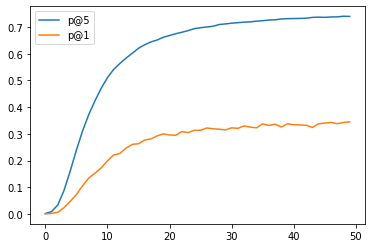

In [ ]:
# Les accuracy sur les mots traduits dans history sont differentes de celles calculées par evaluate
# ex : "une" peut être traduit par "a" / "an" / "one"
# dans l'entrainement du reseau on aura 3 (xi,yi) avec xi vecteur de "une" et donc une perte pour :
#           _ translate(x,precision) ∩ {a} = ∅
#           _ translate(x,precision) ∩ {an} = ∅
#           _ translate(x,precision) ∩ {one} = ∅
# alors que dans evaluate, on aura une perte de 1 si l'intersection suivante vide :
#             translate(x, precision) , {a, an, one}
# -> si translate("une", precision = 1) = ["a"], le réseau aura 2 perte (a!=an et a!=one)
# mais evaluate n'aura pas de perte 

plt.plot(history.history["p@5"], label="p@5")
plt.plot(history.history["p@1"], label="p@1")

plt.legend()

In [ ]:
fr_en_trslt.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

[('homme', ['man', 'woman', 'soldier', 'lawyer']),
 ('femme', ['woman', 'wife', 'mother', 'widowed']),
 ('hiver', ['winter', 'summer', 'autumn', 'winters']),
 ('juin', ['june', 'april', 'july', 'november']),
 ('avion', ['airplane', 'airplanes', 'aircraft', 'airliner'])]

In [ ]:
print("Train: ", fr_en_trslt.evaluate(fr_en_dic, [1, 5, 10]))
print("Test: ", fr_en_trslt.evaluate(fr_en_test_dic, [1, 5, 10]))

Train:  {1: 0.8239450837876034, 5: 0.9254996971532404, 10: 0.9434686048859278}
Test:  {1: 0.7369505494505495, 5: 0.8777472527472527, 10: 0.9093406593406593}


#### Méthode Procrustes
 
Recherche de la matrice $W$ (avec $d_1=d_2$) vérifiant :
 
$$
    \min_{W \in \mathbb{R}^{d_2 \times d_1}, WW^T = I_{d_2}} \sum_{i=1}^{i=n} \|W x_i - y_i\|^2 
$$

In [ ]:
fr_en_trslt.fit(method="procrustes", n_refinement=5)

0.35970829318324526

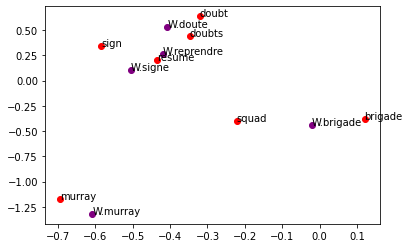

In [ ]:
def g(trslt, n):
    indices = np.random.choice(range(len(trslt.dictionary.keys())), n, False)
    pca = PCA(2).fit(trslt.target.vec)
    
    for i in indices:
        word = list(trslt.dictionary.keys())[i]
        translation = trslt.dictionary[word]
       
        source_vec = np.reshape(trslt.source.vec[np.where(trslt.source.voc == word)[0][0]], (1,trslt.source.embd_size))
        target_vec=[]
        for t in translation:
            target_vec.append(trslt.target.vec[np.where(trslt.target.voc == t)[0][0]])
        target_vec = np.reshape(target_vec, (len(translation),trslt.target.embd_size))
        projection = np.dot(source_vec, trslt.W)
        
        source_point = pca.transform(source_vec)
        target_point = pca.transform(target_vec)
        projection_point = pca.transform(projection)
        
        #plt.scatter(source_point[:,0], source_point[:,1], c='blue')
        #plt.annotate(word, (source_point[:,0], source_point[:,1]))

        plt.scatter(target_point[:,0], target_point[:,1], c='red')
        for t in range(len(translation)):
            plt.annotate(translation[t], (target_point[t,0], target_point[t,1]))
        plt.scatter(projection_point[:,0], projection_point[:,1], c='purple')
        plt.annotate("W."+word, (projection_point[:,0], projection_point[:,1]))

g(fr_en_trslt, 5)

In [ ]:
fr_en_trslt.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

[('homme', ['man', 'politician', 'lawyer', 'businessman']),
 ('femme', ['woman', 'wife', 'daughter', 'mother']),
 ('hiver', ['winter', 'summer', 'olympics', 'autumn']),
 ('juin', ['june', 'april', 'july', 'march']),
 ('avion', ['airplane', 'airliner', 'aircraft', 'airplanes'])]

In [ ]:
print("Train: ", fr_en_trslt.evaluate(fr_en_dic, [1, 5, 10]))
print("Test: ", fr_en_trslt.evaluate(fr_en_test_dic, [1, 5, 10]))

Train:  {1: 0.8402988088027458, 5: 0.9319604280234202, 10: 0.9485160508782556}
Test:  {1: 0.7802197802197802, 5: 0.8962912087912088, 10: 0.9210164835164835}


#### Traducteur sans dictionnaire donné.

(Un dictionnaire est construit en usant des mots communs (ayant une meme orthographe) aux deux langues.

In [ ]:
fr_en_trslt2 = SupervisedTranslator(fr, en) 

In [ ]:
fr_en_trslt2.fit(method="procrustes")

In [ ]:
fr_en_trslt2.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

[('homme', ['politician', 'diplomat', 'man', 'businessman']),
 ('femme', ['woman', 'wife', 'daughter', 'widowed']),
 ('hiver', ['winter', 'summer', 'skiing', 'alpine']),
 ('juin', ['june', 'april', 'november', 'october']),
 ('avion', ['airliner', 'aircraft', 'airplane', 'cessna'])]

In [ ]:
print("Test: ", fr_en_trslt2.evaluate(fr_en_test_dic, [1, 5, 10]))

Test:  {1: 0.7651098901098901, 5: 0.8770604395604396, 10: 0.9086538461538461}


Traduction anglais -> français en transposant la matrice de français -> anglais

In [ ]:
en_fr_trslt.W = fr_en_trslt.W.T
print("Train: ", en_fr_trslt.evaluate(en_fr_dic, [1, 5, 10]))
print("Test: ", en_fr_trslt.evaluate(en_fr_test_dic, [1, 5, 10]))

Train:  {1: 0.8146124266342846, 5: 0.9145921878162315, 10: 0.9360453349524388}
Test:  {1: 0.8080326752893124, 5: 0.9169503063308373, 10: 0.9319264805990469}


Traduction anglais -> français en entraînant

In [ ]:
en_fr_trslt.fit(method="procrustes")
print("Train: ", en_fr_trslt.evaluate(en_fr_dic, [1, 5, 10]))
print("Test: ", en_fr_trslt.evaluate(en_fr_test_dic, [1, 5, 10]))

Train:  {1: 0.8295891519935236, 5: 0.9234972677595629, 10: 0.9415098158267557}
Test:  {1: 0.7882913546630361, 5: 0.9046970728386657, 10: 0.9305650102110279}


#### Comparaison MGD Procuste

Influence de la taille du dictionnaire

In [ ]:
# Procrustes
stats = {}
for i in range(200, 8201, 200):
    fr_en_trslt = SupervisedTranslator(fr, en, fr_en_dic.loc[:i,:])
    fr_en_trslt.fit(method="procrustes")
    stats[i] = fr_en_trslt.evaluate(fr_en_test_dic, [1, 5, 10])

In [ ]:
# MGD
stats2 = {}
for i in range(200, 8201, 200):
    print(i)
    fr_en_trslt = SupervisedTranslator(fr, en, fr_en_dic.loc[:i,:])
    fr_en_trslt.fit(method="NN", step_size=0.1, batch_size=4, epochs=60, verbose=0)
    stats2[i] = fr_en_trslt.evaluate(fr_en_test_dic, [1, 5, 10])

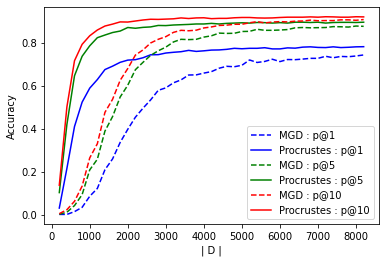

In [ ]:
colors = {1:"blue", 5:"green", 10:"red"}
x = list(stats.keys())
y = {}
y2 = {}
for i in stats.keys():
    for j in stats[i].keys():
        if j not in y.keys():
            y[j] = []
            y2[j] = []
        y[j].append(stats[i][j])
        y2[j].append(stats2[i][j])

for i in y.keys():
    plt.plot(x, y2[i], "--", c=colors[i], label=str("MGD : p@"+str(i)))
    plt.plot(x, y[i], c=colors[i], label=str("Procrustes : p@"+str(i)))
plt.xlabel("| D |")
plt.ylabel("Accuracy")
plt.legend();
plt.savefig("MGD_vs_Procrutes.jpg")

### Traduction non supervisée

1.   Apprentissage d'une projection linéaire W par Apprentissage Adversarial.

     1.1 Discriminant

     1.2 Apprentissage de la projection W  (Aussi, la matrice W est orthogonalisée pendant l'apprentissage)
     

2.   Rafinement de W apprise en 1 par Procrustes, Procrustes nécessite un dictionnaire donc un dictionnaire synthétique est d'abbord construit en utilisant la W apprise. 

     2.1 Dictionnaire synthétique

     2.2 Procrustes

3.   Rapprochement des projetés et des mots de la langue cible (équiv. étape plus proches voisins ci-haut) en utilisant la métrique CSLS.


Entrainement GAN

In [ ]:
epochs=70
fr_en_trslt_un= UnsupervisedTranslator(fr,en)
X,y,d = fr_en_trslt_un.process(fr_en_test_dic)              #test_dic # X et y sont utilises pour savoir quand diviser par 2 le learning rate
d_history, g_history= fr_en_trslt_un.fit(epochs=epochs,batch_size=50,test_dic=fr_en_test_dic)
fr_en_trslt_un.save_mapping("generator_mapping")
W=fr_en_trslt_un.W

In [ ]:
fr_en_trslt_un.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

Raffinement par Procruste itératif

In [ ]:
params= (50,fr_en_trslt_un.source.vec.shape[0], 0)
fr_en_trslt_un.procrustes_refinement(30, params)
fr_en_trslt_un.save_mapping("refined_mapping")

In [ ]:
fr_en_trslt_un.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

In [ ]:
#(tout ce qui suit est l'ancienne execution avant l'ajout de la division du taux d'apprentissage par deux selon la métrique csls)
epochs=70
fr_en_trslt_un= UnsupervisedTranslator(fr,en)
X,y,d = fr_en_trslt_un.process(fr_en_test_dic) #test_dic # X et y sont utilises pour savoir quand diviser par 2 le learning rate
d_history, g_history= fr_en_trslt_un.fit(epochs=70,batch_size=50,test_dic=fr_en_test_dic)

lr  0.098000005
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.09604
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.094119206
translations acc  {1: 0.0, 5: 0.0, 10: 0.002364066193853428}
lr  0.092236824
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.09039209
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
4
D_loss:  0.582 , D_acc1:  0.76 , G_loss:  1.009 , G_acc:  0.12
0.8432182103413921
lr  0.08858425
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.08681256
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.042538155
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.04168739
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.040853646
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
9
D_loss:  0.491 , D_acc1:  0.9 , G_loss:  1.557 , G_acc:  0.08
0.843258989753812
lr  0.040036574
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.01961792
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.019225562
translations acc  {1: 0.0, 5: 0.0, 10: 0.0}
lr  0.01884105
translations acc  {1: 0.0, 5: 0

In [ ]:
#mais
fr_en_trslt_un.translate(["homme", "femme", "hiver", "juin", "avion"], 4)

[('homme', ['grids', 'positioning', 'pins', 'flash']),
 ('femme', ['synchronization', 'synchronous', 'increments', 'dynamically']),
 ('hiver', ['pm', 'whitecaps', 'weekends', 'interiors']),
 ('juin', ['lots', 'actual', 'whats', 'makes']),
 ('avion', ['fulton', 'walnut', 'delano', 'genesee'])]

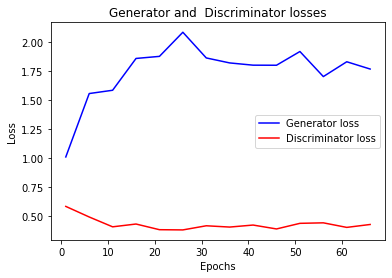

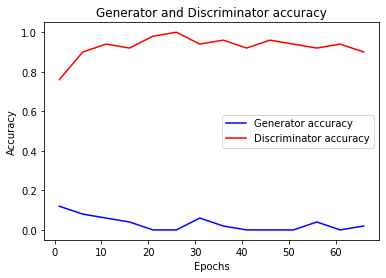

In [ ]:
import matplotlib.pyplot as plt
#loss
g_loss_values = g_history['loss']
d_loss_values = d_history['loss']
epoch_vals = range(1, epochs, 5)
plt.plot(epoch_vals, g_loss_values, 'b', label='Generator loss')
plt.plot(epoch_vals, d_loss_values, 'r', label='Discriminator loss')
plt.title('Generator and  Discriminator losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#accuracy  
g_acc_values = g_history['acc']
d_acc_values = d_history['acc']
epoch_vals = range(1, epochs, 5)
plt.plot(epoch_vals, g_acc_values, 'b', label='Generator accuracy')
plt.plot(epoch_vals, d_acc_values, 'r', label='Discriminator accuracy')
plt.title('Generator and Discriminator accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
